In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 63 bytes


In [2]:
! kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [01:08<00:00, 39.5MB/s]
100% 2.29G/2.29G [01:08<00:00, 35.8MB/s]


In [3]:
!unzip chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0448-0001.jpeg  
  inflating: ches

In [5]:
import os
base_dir = '/content/chest_xray'
test_dir = os.path.join(base_dir,'test')
train_dir = os.path.join(base_dir,'train')
val_dir = os.path.join(base_dir,'val')

In [6]:
os.listdir('/content/chest_xray/test')

['NORMAL', 'PNEUMONIA']

In [7]:
os.listdir('/content/chest_xray/train')

['NORMAL', 'PNEUMONIA']

In [8]:
os.listdir('/content/chest_xray/val')

['NORMAL', 'PNEUMONIA']

In [13]:
train_nor_dir = os.path.join(train_dir,'NORMAL')

train_pneu_dir = os.path.join(train_dir,'PNEUMONIA')

test_nor_dir = os.path.join(test_dir,'NORMAL')

test_pneu_dir = os.path.join(test_dir,'PNEUMONIA')

In [14]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')
 
test_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')

In [15]:
train_generator = train_datagen.flow_from_directory(
        train_dir,  # direktori data latih
        target_size=(150, 150),  # mengubah resolusi seluruh gambar menjadi 150x150 piksel
        batch_size=4,
        # karena kita merupakan masalah klasifikasi 2 kelas maka menggunakan class_mode = 'binary'
        class_mode='binary')
 
validation_generator = test_datagen.flow_from_directory(
        test_dir, # direktori data validasi
        target_size=(150, 150), # mengubah resolusi seluruh gambar menjadi 150x150 piksel
        batch_size=4, # karena kita merupakan masalah klasifikasi 2 kelas maka menggunakan class_mode = 'binary'
        class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [23]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(rate=.2),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [24]:
model.compile(loss='binary_crossentropy',
              optimizer = tf.optimizers.Adam(),
              metrics=['accuracy'])

In [25]:
# set max accuracy
max_val_acc = 0.96

In [26]:
# membuat kelas warning jika validation accuracy telah mencapai 96% stop
class warn(tf.keras.callbacks.Callback):
	def on_epoch_end(self, epoch, logs={}):
		if((logs.get('val_accuracy') > max_val_acc) and (logs.get('accuracy') > max_val_acc)):
			print("\nMax accuracy reached %2.2f%%, training stopped." %(max_val_acc*100))
			self.model.stop_training = True

callbacks = warn()

In [27]:
history = model.fit(
      train_generator,
      steps_per_epoch=25,  # berapa batch yang akan dieksekusi pada setiap epoch
      epochs=30,
      validation_data=validation_generator, # menampilkan akurasi pengujian data validasi
      validation_steps=5,  # berapa batch yang akan dieksekusi pada setiap epoch
      verbose=2,
      callbacks=[callbacks]
      )

Epoch 1/30
25/25 - 7s - loss: 0.6945 - accuracy: 0.7500 - val_loss: 0.9092 - val_accuracy: 0.4500
Epoch 2/30
25/25 - 7s - loss: 0.6520 - accuracy: 0.7200 - val_loss: 0.6449 - val_accuracy: 0.7000
Epoch 3/30
25/25 - 7s - loss: 0.6164 - accuracy: 0.7100 - val_loss: 0.8037 - val_accuracy: 0.5000
Epoch 4/30
25/25 - 7s - loss: 0.5986 - accuracy: 0.7300 - val_loss: 0.7504 - val_accuracy: 0.5000
Epoch 5/30
25/25 - 7s - loss: 0.4985 - accuracy: 0.8200 - val_loss: 0.6006 - val_accuracy: 0.7500
Epoch 6/30
25/25 - 7s - loss: 0.4611 - accuracy: 0.7900 - val_loss: 1.0116 - val_accuracy: 0.7500
Epoch 7/30
25/25 - 7s - loss: 0.6274 - accuracy: 0.7600 - val_loss: 0.4953 - val_accuracy: 0.8000
Epoch 8/30
25/25 - 7s - loss: 0.5580 - accuracy: 0.7800 - val_loss: 0.7034 - val_accuracy: 0.5500
Epoch 9/30
25/25 - 7s - loss: 0.5000 - accuracy: 0.8300 - val_loss: 0.6497 - val_accuracy: 0.6500
Epoch 10/30
25/25 - 7s - loss: 0.6106 - accuracy: 0.7100 - val_loss: 0.7006 - val_accuracy: 0.5500
Epoch 11/30
25/25 -

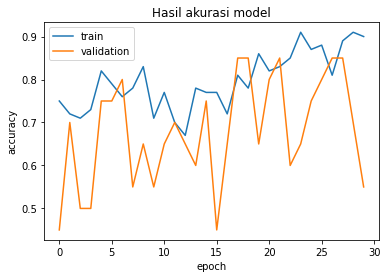

In [28]:
import matplotlib.pyplot as plt

# visualisasi akurasi hasil dari training
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Hasil akurasi model')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train','validation'])
plt.show()

Saving NORMAL2-IM-1427-0001.jpeg to NORMAL2-IM-1427-0001 (1).jpeg
[[2.1301632e-12]]
NORMAL2-IM-1427-0001.jpeg
Normal


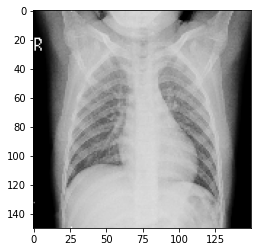

In [33]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
 
uploaded = files.upload()
 
for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(150,150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
 
  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes)
  print(fn)
  if classes < 1:
    print('Normal')
  else:
    print('Pneumonia')